# Importing libraries

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
import seaborn as sns
from sklearn.cluster import KMeans

### Ignoring warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
dataFrame = pd.read_csv('../data/week1_challenge.csv', na_values=['?', None])

In [5]:
#rename columns
dataFrame=dataFrame.rename(columns = {'Total DL (Bytes)' : 'totalDL','Total UL (Bytes)' : 'totalUL','Dur. (ms)' : 
                                      'dur','MSISDN/Number':'MSISDN','Last Location Name':'location',
                                      'Handset Manufacturer':'manufacturer','Handset Type':'handset',
                                      'Avg RTT DL (ms)':'AVG RTT DL',
                                      'Avg RTT UL (ms)':'AVG RTT UL',
                                      'Avg Bearer TP UL (kbps)':'AVG TP UL',
                                      'Avg Bearer TP DL (kbps)':'AVG TP DL',
                                      'TCP UL Retrans. Vol (Bytes)':'TCP UL Retrans',
                                      'TCP DL Retrans. Vol (Bytes)':'TCP DL Retrans'
                                      
                                     
                                     })


userExperienceDF=dataFrame[['handset','AVG RTT DL','AVG RTT UL','TCP UL Retrans','TCP DL Retrans','AVG TP UL','AVG TP DL']]

### The following cell handles null values in the dataset by replacing categorical values with the mode and continuous values with the mean.

In [6]:
sumNull = userExperienceDF.isnull().sum()
print(sumNull)
for column in userExperienceDF.columns:
    if(column=='handset'):
        userExperienceDF[column] = userExperienceDF[column].fillna( userExperienceDF[column].mode().values[0] )
        userExperienceDF[column] = userExperienceDF[column].replace(['undefined'],userExperienceDF[column].mode().values[0])
    else:
        userExperienceDF[column] = userExperienceDF[column].fillna( userExperienceDF[column].mean() )

sumNull = userExperienceDF.isnull().sum()
sumNull

handset             572
AVG RTT DL        27829
AVG RTT UL        27812
TCP UL Retrans    96649
TCP DL Retrans    88146
AVG TP UL             1
AVG TP DL             1
dtype: int64


handset           0
AVG RTT DL        0
AVG RTT UL        0
TCP UL Retrans    0
TCP DL Retrans    0
AVG TP UL         0
AVG TP DL         0
dtype: int64

### The following plots help us visualize to what extent the experience metrics are affected by outliers.

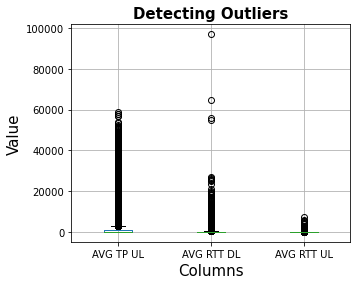

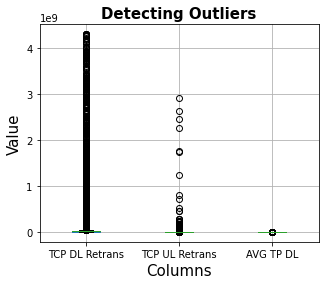

In [7]:

fig, ax = plt.subplots(figsize=(5,4))
ax=userExperienceDF[['AVG TP UL','AVG RTT DL','AVG RTT UL']].boxplot(ax=ax)
ax.set_xlabel('Columns', fontsize=15)
ax.set_ylabel('Value' , fontsize=15)
ax.set_title('Detecting Outliers', fontsize=15, fontweight='bold')
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('Columns', fontsize=15)
ax.set_ylabel('Value' , fontsize=15)
ax.set_title('Detecting Outliers', fontsize=15, fontweight='bold')
ax=userExperienceDF[['TCP DL Retrans','TCP UL Retrans','AVG TP DL']].boxplot(ax=ax)

### The following plots show that the outliers no longer exist. 

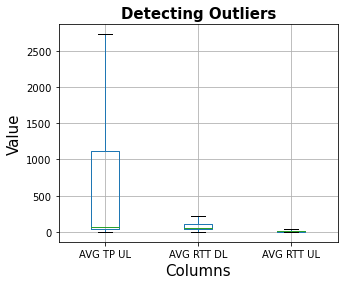

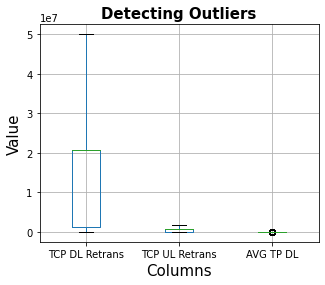

In [8]:
columns=userExperienceDF.columns
i=1
for column in columns:
    if(column!='handset'):
        Q1=userExperienceDF[column].quantile(0.25)
        Q3=userExperienceDF[column].quantile(0.75)
        IQR=Q3-Q1
        Lower_Whisker = Q1-1.5*IQR
        Upper_Whisker = Q3+1.5*IQR
        #print(Lower_Whisker, Upper_Whisker)
        userExperienceDF.loc[userExperienceDF[column] > Upper_Whisker, column] = userExperienceDF[column].mean()
    
fig, ax = plt.subplots(figsize=(5,4))
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(5,4))
ax=userExperienceDF[['AVG TP UL','AVG RTT DL','AVG RTT UL']].boxplot(ax=ax)
ax.set_xlabel('Columns', fontsize=15)
ax.set_ylabel('Value' , fontsize=15)
ax.set_title('Detecting Outliers', fontsize=15, fontweight='bold')
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('Columns', fontsize=15)
ax.set_ylabel('Value' , fontsize=15)
ax.set_title('Detecting Outliers', fontsize=15, fontweight='bold')
ax=userExperienceDF[['TCP DL Retrans','TCP UL Retrans','AVG TP DL']].boxplot(ax=ax)

In [9]:
userExperienceDF['AVG TCP'] = userExperienceDF['TCP UL Retrans']+userExperienceDF['TCP DL Retrans']
userExperienceDF['AVG RTT'] = userExperienceDF['AVG RTT UL']+userExperienceDF['AVG RTT DL']
userExperienceDF['AVG TP'] = userExperienceDF['AVG TP UL']+userExperienceDF['AVG TP DL']

### The following cell aggregates the experience metrics for each customer. The handset column represents the number of unique handsets used by each user.

In [10]:
userExperienceDF['MSISDN'] = dataFrame['MSISDN']
userExperienceTotalDF=userExperienceDF[['MSISDN','AVG TCP','AVG RTT','AVG TP','handset']]
experiencePerUserDF = userExperienceTotalDF.groupby('MSISDN').sum()

experiencePerUserDF['No of Handset'] = userExperienceTotalDF.groupby('MSISDN')['handset'].nunique()
experiencePerUserDF

,AVG TCP,AVG RTT,AVG TP,No of Handset
MSISDN,,,,
3.360100e+10,2.156957e+07,46.000000,76.000000,1
3.360100e+10,2.156957e+07,31.000000,99.000000,1
3.360100e+10,2.156957e+07,127.458589,97.000000,1
3.360101e+10,7.607247e+05,84.000000,248.000000,1
3.360101e+10,3.094040e+07,119.000000,42205.428647,1
...,...,...,...,...
3.379000e+10,2.180450e+05,52.000000,10365.000000,1
3.379000e+10,2.156957e+07,40.000000,116.000000,1
3.197021e+12,2.156957e+07,127.458589,1.000000,1


## The following are the top 10 most frequent values of each experience metric.

In [11]:
print(' \nTop 10 based on TCP Retransmission\n')
print(experiencePerUserDF['AVG TCP'].value_counts().head(10))
print(' \nTop 10 based on RTT\n')
print(experiencePerUserDF['AVG RTT'].value_counts().head(10))
print(' \nTop 10 based on Throuput\n')
experiencePerUserDF['AVG TP'].value_counts().head(10)

 
Top 10 based on TCP Retransmission

2.156957e+07    47128
4.313915e+07     7468
6.470872e+07     1032
2.081121e+07      363
8.627829e+07      252
2.081124e+07      167
2.156957e+07      159
7.609887e+05      145
4.238078e+07       82
2.081123e+07       81
Name: AVG TCP, dtype: int64
 
Top 10 based on RTT

127.458589    16838
29.000000      2736
39.000000      2162
254.917178     1945
38.000000      1446
30.000000      1419
40.000000      1383
28.000000      1330
49.000000      1194
31.000000      1053
Name: AVG RTT, dtype: int64
 
Top 10 based on Throuput



15070.474573    2770
15.000000       2685
63.000000       2072
97.000000       1023
90.000000       1005
98.000000        971
96.000000        866
99.000000        853
89.000000        817
95.000000        798
Name: AVG TP, dtype: int64

## The following are the top 10 users based on each experience metric.

In [12]:
tcpBasedExperience = experiencePerUserDF.nlargest(10,'AVG TCP')
rttBasedExperience = experiencePerUserDF.nlargest(10,'AVG RTT')
tpBasedExperience = experiencePerUserDF.nlargest(10,'AVG TP')
print(' \nTop 10 based on TCP Retransmission\n')
print(tcpBasedExperience)
print(' \nTop 10 based on RTT\n')
print(rttBasedExperience)
print(' \nTop 10 based on Throughput\n')
print(tpBasedExperience)

 
Top 10 based on TCP Retransmission

                   AVG TCP      AVG RTT         AVG TP  No of Handset
MSISDN                                                               
3.362578e+10  2.621829e+08   735.458589  151441.474573              1
3.376054e+10  2.502067e+08  1803.044479   99056.045927              1
3.362632e+10  2.368500e+08  1314.668712  121345.000000              1
3.366907e+10  2.263020e+08   797.917178   31189.091853              1
3.378632e+10  1.958852e+08  1025.210123   81020.000000              1
3.366469e+10  1.941262e+08  1147.127301     741.000000              1
3.367650e+10  1.933667e+08   589.375767   32039.091853              1
3.362708e+10  1.918687e+08  1089.292945   33033.000000              1
3.366564e+10  1.838110e+08   803.000000  192904.143233              1
3.366709e+10  1.822102e+08   589.314415  151985.000000              1
 
Top 10 based on RTT

                   AVG TCP      AVG RTT         AVG TP  No of Handset
MSISDN                       

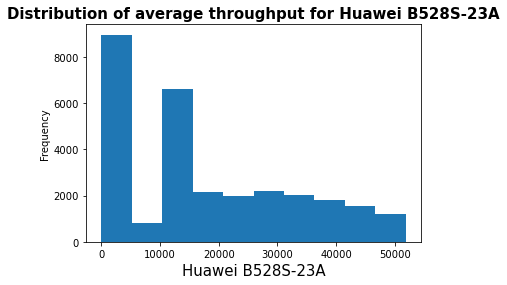

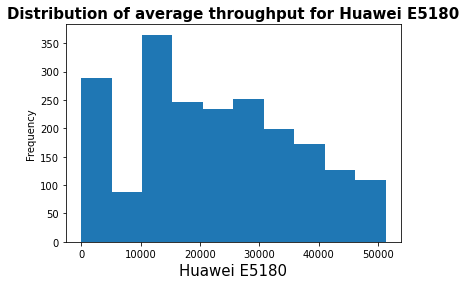

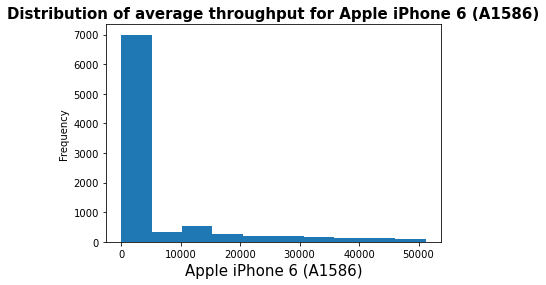

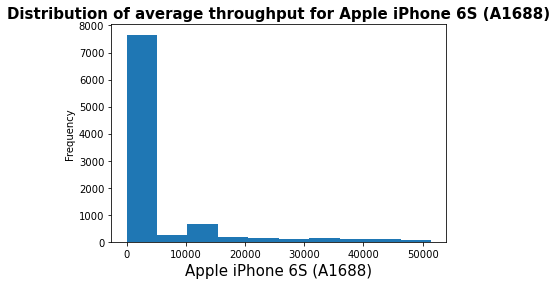

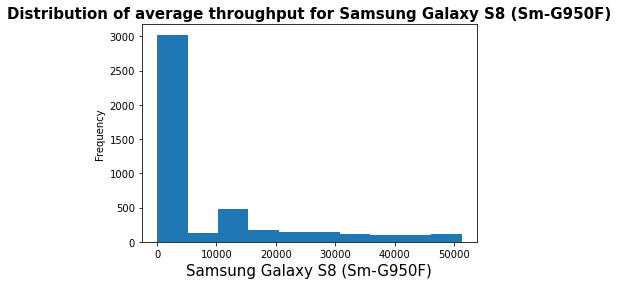

In [13]:
# find the top 5 handsets with total average throughput.
largestTP = userExperienceTotalDF.groupby('handset')['AVG TP'].sum().nlargest(5)


grouped=userExperienceTotalDF.groupby('handset')

for handset in largestTP.index:
    plt.figure()
    ax=grouped.get_group(handset)['AVG TP'].plot.hist()
    ax.set_xlabel(handset, fontsize=15)
    ax.set_title('Distribution of average throughput for '+ handset, fontsize=15, fontweight='bold')

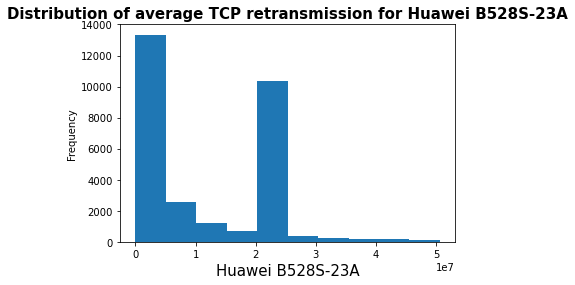

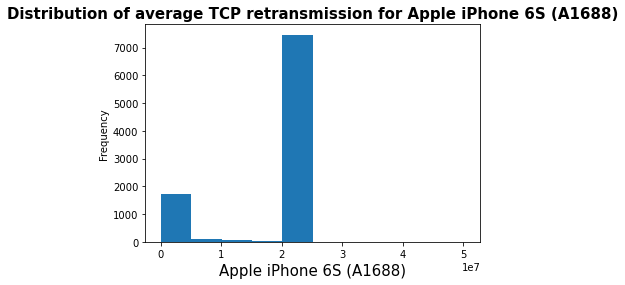

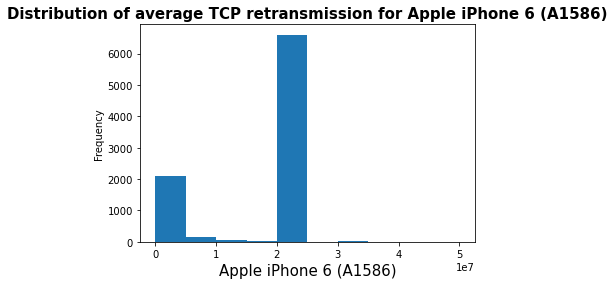

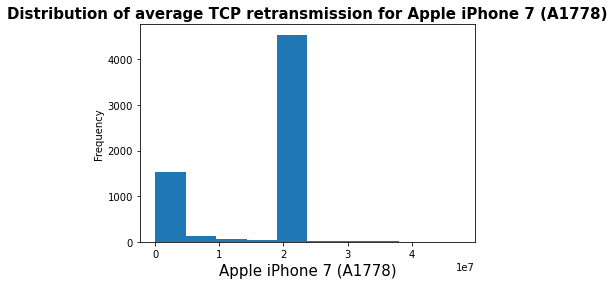

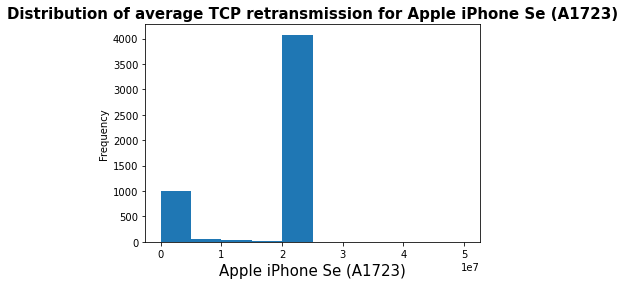

In [14]:
largestTP = userExperienceTotalDF.groupby('handset')['AVG TCP'].sum().nlargest(5)


grouped=userExperienceTotalDF.groupby('handset')

for handset in largestTP.index:
    plt.figure()
    ax=grouped.get_group(handset)['AVG TCP'].plot.hist()
    ax.set_xlabel(handset, fontsize=15)
    ax.set_title('Distribution of average TCP retransmission for '+ handset, fontsize=15, fontweight='bold')

### The following cell runs k-means algorithm on the experience metrics with k=3.

In [15]:
x = experiencePerUserDF[['AVG TCP','AVG RTT','AVG TP']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled,columns=['AVG TCP','AVG RTT','AVG TP'])
KMean_clust= KMeans(n_clusters=3, init='k-means++',max_iter=1000)
KMean_clust.fit(normalized)
metricDF=experiencePerUserDF[['AVG TCP','AVG RTT','AVG TP']]
metricDF['Cluster']=KMean_clust.labels_
metricDF

,AVG TCP,AVG RTT,AVG TP,Cluster
MSISDN,,,,
3.360100e+10,2.156957e+07,46.000000,76.000000,1
3.360100e+10,2.156957e+07,31.000000,99.000000,1
3.360100e+10,2.156957e+07,127.458589,97.000000,1
3.360101e+10,7.607247e+05,84.000000,248.000000,2
3.360101e+10,3.094040e+07,119.000000,42205.428647,2
...,...,...,...,...
3.379000e+10,2.180450e+05,52.000000,10365.000000,2
3.379000e+10,2.156957e+07,40.000000,116.000000,1
3.197021e+12,2.156957e+07,127.458589,1.000000,1


In [16]:
clusteredMean = metricDF.groupby('Cluster').mean()
clusteredMean

,AVG TCP,AVG RTT,AVG TP
Cluster,,,
0,3.792151e+07,375.682825,84341.961000
1,2.643764e+07,95.464594,2483.454060
2,5.369481e+06,99.597559,21390.423562


1    68576
2    33898
0     4382
Name: Cluster, dtype: int64

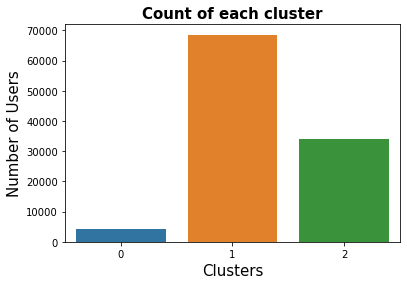

In [17]:
clusteredDF=metricDF['Cluster'].value_counts()
ax=sns.barplot(clusteredDF.index, clusteredDF.values)
ax.set_xlabel('Clusters', fontsize=15)
ax.set_ylabel('Number of Users' , fontsize=15)
ax.set_title('Count of each cluster', fontsize=15, fontweight='bold')
clusteredDF